# Pythonradex
Re-implementation of the RADEX code.
Adventages of pythonradex:
- faster
- provides a convenient method to read files from the LAMDA database, official website: https://home.strw.leidenuniv.nl/~moldata/.
- provides additional functionality that is not included in RADEX (treatment of overlapping lines)
- RADEX calculates the flux for all geometries using the equation which is only valid for slab geometry, pythonradex uses the correct formulae for spherical geometries.



In [1]:
import pythonradex

# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file, atomic_transition
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [2]:
print(dir(pythonradex))

['LAMDA_file', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'atomic_transition', 'escape_probability', 'escape_probability_functions', 'flux', 'helpers', 'molecule', 'radiative_transfer', 'rate_equations']


# Getting started with pythonradex

- Radiative transfer calculation is conducted using the Cloud class which is provided by the radiative_transfer module
- Possible geometries: "Gaussian",  “rectangular”, "LVG sphere", "LVG slab”
- For LVG geometries the parameter "line_profile_type" needs to be set to “rectangular”. This ensures that the optical depth is calculated correctly.


In [3]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CO from LAMBDA database
datafilepath = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\co_datafile.dat"  # file downloaded from LAMDA database


# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
line_profile_type = "Gaussian"  # line profile, can be "Gaussian",  “rectangular”,"LVG sphere", "LVG slab”
width_v = 2 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud = radiative_transfer.Cloud(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

## line width parameter "width_v" explained
- There are different interpretations of the input parameter width_v used by pythonradex
-  For static geometries, this refers to the local emission width, two kinds of local emission profiles:

  - "Gaussian" in which case width_v refers to the FWHM
  - "rectangular" in which case width_v refers to the FWHM
- For the LVG geometries (“LVG sphere” and “LVG slab”), width_v refers to the global velocity width of the cloud

## Set the parameters characterising the cloud physical conditions.
- use update_parameters method to do this.


In [4]:
## possible atributes of the cloud object
# update_parameters
# solve_radiative_transfer()
# fluxes_of_individual_transitions(solid_angle, transitions)

In [5]:
N = 1e16 / constants.centi**2  # CO column density in m-2
Tkin = 30  # kinetic temperature in [K]

# collider densities in cm-3:
para_h2_density = 1e8
ortho_h2_density = 3e8

# collider densities in m-3:
collider_densities_LTE = {
    "para-H2": para_h2_density / constants.centi**3,
    "ortho-H2": ortho_h2_density / constants.centi**3,
}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_LTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer equation, i.e. calculate the level population with an iterative method
cloud.solve_radiative_transfer()

In [6]:
# print the results
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      30.00      0.0893997       0.223034       0.106957
   2    1     230.538000      30.00       0.223034        0.25707       0.325611
   3    2     345.795990      30.00        0.25707        0.20698       0.465028
   4    3     461.040768      30.00        0.20698       0.127276       0.437055
   5    4     576.267931      30.00       0.127276      0.0618734       0.301009
   6    5     691.473076      30.00      0.0618734      0.0241877        0.15928
   7    6     806.651806      30.00      0.0241877     0.00767775      0.0664206
   8    7     921.799700      29.99     0.00767775     0.00199088      0.0221496
   9    8    1036.912393      29.99     0.00199088    0.000423427     0.00596503
  10    9    1151.985452      29.99    0.000423427    7.40754e-05     0.00130536
  11   10    1267.014486      29.99    7.40754e-05    1.06812e-05    0.000233545
  12   11    1381.995105   

‘poplow’ and ‘popup’ gives the fracitional populations of the lower and upper level respectively, and ‘tau_nu0’ the optical depth at the line centre.

### How fractional population is defined:

Column density of the upper state $N_u$
Fractional population of the upper  level  $n_u$ is the proportion of particles in the upper state relative to the total population of the species ($N_{tot}$):
$$n_u = \frac{N_u}{N_{tot}}$$

# Functions:  Values extraction and gamma/tau calculator

The average_over_phi_nu method calculates the weighted average of a given function func over the line profile phi_nu. This is useful in radiative transfer calculations where you need to average a quantity over the line profile of a spectral line.

In [7]:
def phi_nu_gaussian(nu0, width_nu, n_elements):
    """Gaussian line profile function."""
    sigma_nu = helpers.FWHM2sigma(width_nu)
    normalisation = 1 / (sigma_nu * np.sqrt(2 * np.pi))
    nu = np.linspace(nu0 - width_nu / 2, nu0 + width_nu / 2, n_elements)
    return normalisation * np.exp(-((nu - nu0) ** 2) / (2 * sigma_nu**2))


def weighted_average_gaussian(nu0, width_nu, func):
    """Calculate the weighted average of a given function func over a Gaussian line profile."""

    width = 2  # units of width_nu
    elements_per_width = 20
    old_average = np.inf
    residual = np.inf
    niter = 0
    while residual > 1e-2:
        n_elements = int(elements_per_width * width)
        nu = np.linspace(nu0 - width / 2 * width_nu, nu0 + width / 2 * width_nu, n_elements)
        phi_nu = phi_nu_gaussian(nu0, width_nu, n_elements)
        norm = np.trapz(y=phi_nu, x=nu)
        new_average = np.trapz(y=func(nu) * phi_nu, x=nu) / norm
        residual = helpers.relative_difference(a=np.array((new_average,)), b=np.array((old_average,)))
        old_average = new_average
        width += 1.3
        elements_per_width += 15
        niter += 1
    return new_average


In [8]:
def extract_and_calculate(cloud_name, data_of_molecule, colum_density_species, width_v, Tkin):
    """Extract values from the cloud object and the data file, and calculate gamma factor and optical depth.


    Parameters
    ----------
    cloud_name : pythonradex.radiative_transfer.Cloud
        The cloud object that contains the radiative transfer solution.
    data_of_molecule : dict
        The data file of the molecule.
    colum_density_species : float
        Total column density of the species in m^-2.
    width_v : float
        Width in m/s.
    Tkin : float
        Kinetic temperature in Kelvin.


    Returns
    --------
    Tex: np.array
        The excitation temperature of the molecule.
    tau: np.array
        The optical depth of the transitions.
    Aul : np.array
        The Einstein coefficient for spontaneous emission.
    Bul : np.array
        The Einstein coefficient for stimulated emission.
    nu0_array : np.array
        The frequency of the transition in Hz.
    Eu : np.array
        The energy of the upper level in Kelvin.
    g_weigth : np.array
        The statistical weight of the upper level.
    gamma: np.array
        Gamma factors.

    tau_manual_standard: np.array
        Numpy array of optical depths calculated from standard equation.
    tau_manual: np.array
        Numpy array of optical depths calculated from equation.

    Nu: np.array
        Upper level population density.
    Nl: np.array
        Lower level population density.
    """

    # Extract values
    Tex = cloud_name.Tex
    Aul = cloud_name.emitting_molecule.A21
    Bul = cloud_name.emitting_molecule.B21
    # get the frequency of the transition in Hz
    nu0_array = cloud_name.emitting_molecule.nu0
    tau = cloud_name.tau_nu(nu0_array)

    levels = data_of_molecule["levels"]
    rad_transitions = data_of_molecule["radiative transitions"]
    # coll_transitions = data_of_molecule["collisional transitions"]
    # quantum_numbers = data_of_molecule["quantum numbers"]

    # print statements for debugging
    print("Size of levels:", len(levels))
    print("Size of rad_transitions:", len(rad_transitions))
    print("Size of nu0_array:", len(nu0_array))

    # This line extracts the "E" attribute from each object in levels and converts it to a NumPy array
    # and convert energies from jouls to kelvin
    Eu = np.array([level.E for level in levels]) / constants.k
    Eu = Eu[1:]  # remove first component, sinze the first is nan

    # get the statistical weight of the upper level
    g_weigth = np.array([level.g for level in levels])
    # g_weigth = g_weigth[1:]

    # second possible method to extract optical depth
    tau_extraction_method2 = cloud_name.tau_nu0_individual_transitions

    # compute upper level population density, given by: fractional population density x total column density
    # cloud.level_pop gives the fractional population density of lowest level (len 41), by removing the first element we get the fractional population density of the upper levels
    Nu = cloud_name.level_pop[1:] * colum_density_species
    # get lower level population density
    Nl = cloud_name.level_pop[0:-1] * colum_density_species

    # Convert width to frequency width
    FWHM_each_transition = nu0_array * (width_v / constants.c)

    # print len of each array, for debugging
    # print("len of tau:", len(tau))
    # print("len of nu0_array:", len(nu0_array))
    # print("len of Eu:", len(Eu))
    # print("len of g_weigth:", len(g_weigth))
    # print("len of FWHM_each_transition:", len(FWHM_each_transition))
    # print("len of Nu:", len(Nu))
    # print("len of Nl:", len(Nl))

    # calculate the optical depth, using approximation that line profile function is approximately 1/FWHM
    tau_manual_standard = (
        (constants.c**2 / (8 * np.pi * nu0_array**2))
        * Aul
        * ((Nl * g_weigth[1:] / g_weigth[:-1]) - Nu)
        / FWHM_each_transition
    )

    # use phi_nu function to calculate the optical depth
    # tau_manual_standard = (
    #     (constants.c**2 / (8 * np.pi * nu0_array**2))
    #     * Aul
    #     * phi_nu_gaussian(nu0_array, FWHM_each_transition)
    #     * ((Nl * g_weigth[1:] / g_weigth[:-1]) - Nu)
    # )

    # calculate the optical depth manually, use exitation temperature of the levels (modified equation from  Goldsmith and Lander)
    tau_manual_tex = ((constants.h * Nu * Bul * nu0_array) / (FWHM_each_transition * (np.pi * 4))) * (
        np.exp((constants.h * nu0_array) / (constants.k * Tex)) - 1
    )

    # calculate gamma factor
    gamma = (8 * np.pi * constants.k * nu0_array**2) / (constants.h * constants.c**3 * Aul)

    print(
        "Are tau_nu function and equation for tau (using kinetic temperature) the same?",
        np.allclose(tau, tau_manual_standard),
    )
    print(
        "Are tau_nu function and equation for tau (using exitation temperature) the same?",
        np.allclose(tau, tau_manual_tex),
    )
    print(
        "Are tau_nu0_individual_transitions function and tau_nu function the same?",
        np.allclose(tau, tau_extraction_method2),
    )

    return Tex, tau, Aul, Bul, nu0_array, Eu, g_weigth, gamma, tau_manual_standard, tau_manual_tex, Nu, Nl

# Read file from the LAMDA database

In [9]:
# store the data
data_co = LAMDA_file.read(datafilepath, read_frequencies=True)
# LAMDA_file returns a dictionary containing the data read from the file.

# Full list of attributes
print(data_co.keys())

dict_keys(['levels', 'radiative transitions', 'collisional transitions', 'quantum numbers'])


In [10]:
# Define the number of transitions as a global variable
NUM_TRANSITIONS = 15

# get the values from the cloud object and the data file
TexCo, tauCo, AulCo, BulCo, nu0_arrayCo, EuCo, gCO, gammaCo, tau_manual_std, tau_manual_tex, NuCo, NlCo = (
    extract_and_calculate(cloud, data_co, N, width_v, Tkin)
)

# Slice the arrays to get only the first NUM_TRANSITIONS transitions
TexCo = TexCo[:NUM_TRANSITIONS]
tauCo = tauCo[:NUM_TRANSITIONS]
AulCo = AulCo[:NUM_TRANSITIONS]
BulCo = BulCo[:NUM_TRANSITIONS]
nu0_arrayCo = nu0_arrayCo[:NUM_TRANSITIONS]
EuCo = EuCo[:NUM_TRANSITIONS]
gCO = gCO[:NUM_TRANSITIONS]
gammaCo = gammaCo[:NUM_TRANSITIONS]
tau_manual_std = tau_manual_std[:NUM_TRANSITIONS]
tau_manual_tex = tau_manual_tex[:NUM_TRANSITIONS]
NuCo = NuCo[:NUM_TRANSITIONS]

Size of levels: 41
Size of rad_transitions: 40
Size of nu0_array: 40
Are tau_nu function and equation for tau (using kinetic temperature) the same? False
Are tau_nu function and equation for tau (using exitation temperature) the same? False
Are tau_nu0_individual_transitions function and tau_nu function the same? True


In [11]:
# compute the flux from the cloud
distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
source_radius = 10 * constants.au  # radius of the source in m
# solid angle of the source
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

fluxCo = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)
# get the flux of the first NUM_TRANSITIONS transitions
fluxCo = fluxCo[:NUM_TRANSITIONS]

## Optical depth investigation

In [12]:
tauCo

array([1.06956841e-01, 3.25611039e-01, 4.65027682e-01, 4.37054822e-01,
       3.01008985e-01, 1.59280143e-01, 6.64205958e-02, 2.21495996e-02,
       5.96503111e-03, 1.30535504e-03, 2.33545213e-04, 3.42213425e-05,
       4.12226394e-06, 4.09108383e-07, 3.34768853e-08])

In [13]:
tau_manual_std

array([1.13852029e-01, 3.46602212e-01, 4.95006631e-01, 4.65230444e-01,
       3.20414138e-01, 1.69548460e-01, 7.07025336e-02, 2.35775183e-02,
       6.34957889e-03, 1.38950739e-03, 2.48601176e-04, 3.64274905e-05,
       4.38801401e-06, 4.35482381e-07, 3.56350403e-08])

In [14]:
tau_manual_tex / tau_manual_std

array([1.        , 1.0000052 , 0.99999096, 1.00000116, 1.00000515,
       0.99999492, 1.00000391, 1.0000005 , 0.99999575, 1.00000424,
       0.99999992, 0.99999753, 0.99999972, 1.00000382, 0.99999717])

In [15]:
tauCo / tau_manual_tex

array([0.93943728, 0.9394324 , 0.93944577, 0.93943619, 0.93943244,
       0.93944205, 0.9394336 , 0.93943681, 0.93944127, 0.93943329,
       0.93943736, 0.9394396 , 0.93943754, 0.93943369, 0.93943994])

In [16]:
tauCo / tau_manual_std

array([0.93943728, 0.93943728, 0.93943728, 0.93943728, 0.93943728,
       0.93943728, 0.93943728, 0.93943728, 0.93943728, 0.93943728,
       0.93943728, 0.93943728, 0.93943728, 0.93943728, 0.93943728])

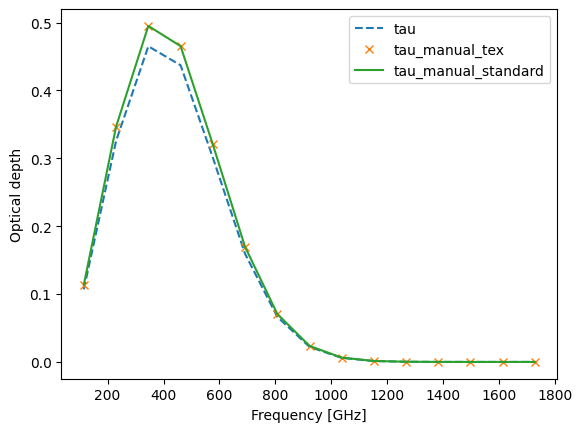

In [17]:
# plot the optical depth
plt.plot(nu0_arrayCo / constants.giga, tauCo, "--", label="tau")
plt.plot(nu0_arrayCo / constants.giga, tau_manual_tex, "x", label="tau_manual_tex")
plt.plot(nu0_arrayCo / constants.giga, tau_manual_std, label="tau_manual_standard")


plt.xlabel("Frequency [GHz]")
plt.ylabel("Optical depth")
plt.legend()
plt.show()


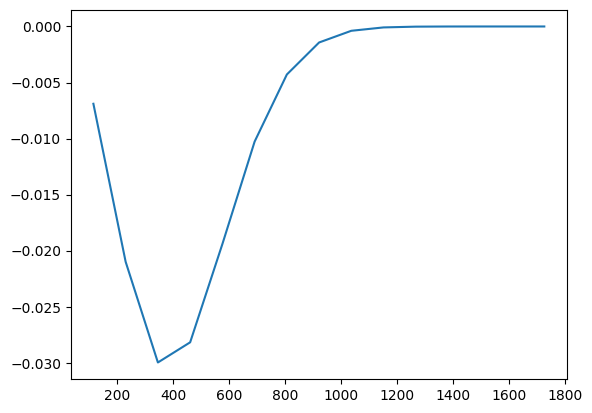

In [18]:
# plot the difference between the two methods
plt.plot(nu0_arrayCo / constants.giga, tauCo - tau_manual_tex, label="tau - tau_manual")

## Population diagram fo CO, LTE case

In [19]:
# Calculate gamma * flux and compare with Nu
gamma_flux = gammaCo * fluxCo
print("gamma * flux (first 5):", gamma_flux[:5])
print("Nu (first 5):", NuCo[:5])
print("Are gamma * flux and Nu the same?", np.allclose(gamma_flux, NuCo))

gamma * flux (first 5): [1.67147170e-08 1.45716168e-07 3.82445894e-07 5.61222247e-07
 5.51186812e-07]
Nu (first 5): [2.23034483e+19 2.57070301e+19 2.06979904e+19 1.27276295e+19
 6.18733960e+18]
Are gamma * flux and Nu the same? False


In [20]:
NuCo

array([2.23034483e+19, 2.57070301e+19, 2.06979904e+19, 1.27276295e+19,
       6.18733960e+18, 2.41877320e+18, 7.67774922e+17, 1.99087527e+17,
       4.23427373e+16, 7.40754299e+15, 1.06811911e+15, 1.27150214e+14,
       1.25116585e+13, 1.01865049e+12, 6.86700056e+10])

In [21]:
gammaCo

array([3.58536382e+15, 1.49489951e+15, 9.30735688e+14, 6.74383090e+14,
       5.28613492e+14, 4.34861572e+14, 3.69570434e+14, 3.21678670e+14,
       2.85092085e+14, 2.56389959e+14, 2.33016990e+14, 2.13953076e+14,
       1.97961708e+14, 1.84345178e+14, 1.72753430e+14])

In [22]:
gammaCo * fluxCo

array([1.67147170e-08, 1.45716168e-07, 3.82445894e-07, 5.61222247e-07,
       5.51186812e-07, 3.85995638e-07, 1.99281173e-07, 7.80192179e-08,
       2.37202311e-08, 5.69721808e-09, 1.09329584e-09, 1.68901664e-10,
       2.11209295e-11, 2.14660383e-12, 1.77887571e-13])

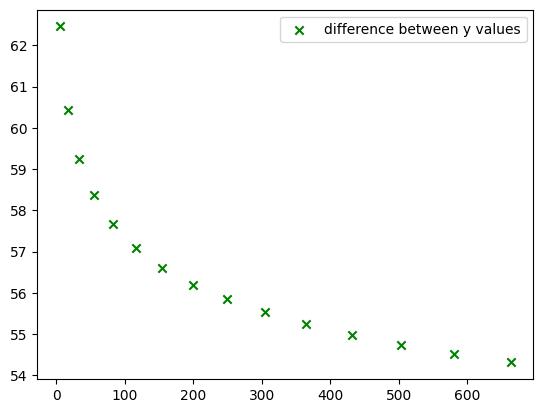

In [23]:
# calculate escape probability for each transition
beta = (1 - np.exp(-tauCo)) / tauCo
# Replace 0 with nan in beta
beta[beta == 0] = np.nan

# get the y axis of the plot: ln(γ_u * W / g_u)
y_values = np.log(gammaCo * fluxCo / gCO)

# calculate get y values using column density of the upper level
y_values_Nu = np.log(NuCo / gCO)
# calculate y values using column density of the upper level and beta
y_value_Nu_beta_consideration = np.log(NuCo / (beta * gCO))

diff_beta = y_values_Nu - y_values

# plot population diagram
fig, ax = plt.subplots()

# plot y values considering escape probaility
plt.scatter(EuCo, diff_beta, marker="x", color="green", label="difference between y values")
plt.legend()


In [24]:
y_values / y_values_Nu

array([-0.40194084, -0.38629062, -0.38225364, -0.38861442, -0.40437506,
       -0.42986526, -0.46594369, -0.51379482, -0.5751585 , -0.65267237,
       -0.75026858, -0.87377013, -1.03195488, -1.2385394 , -1.51607562])

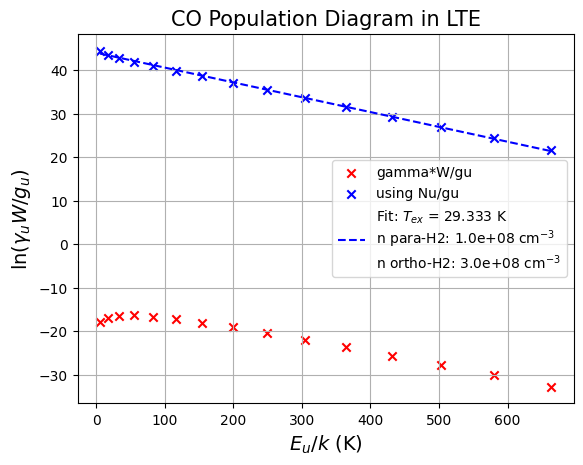

In [25]:
# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCo, y_values, marker="x", color="red", label="gamma*W/gu")
plt.scatter(EuCo, y_values_Nu, marker="x", color="blue", label="using Nu/gu")

# plot y values considering escape probaility
# plt.scatter(EuCo, y_value_new_beta_consideration, marker="x", color="green", label="considering beta and Nu")


plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# # Fit a straight line to estimate T_ex
fit = np.polyfit(EuCo, y_values_Nu, 1)  # Linear fit
T_ex = -1 / fit[0]  # Rotational temperature from slope

# Plot the best-fit line
x_fit = np.linspace(min(EuCo), max(EuCo), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(
        f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\nn para-H2: {para_h2_density:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density:.1e} cm$^{{-3}}$"
    ),
)
plt.legend()
ax.grid()
plt.show()

### why the the two y axis are different???

## Final population diagram

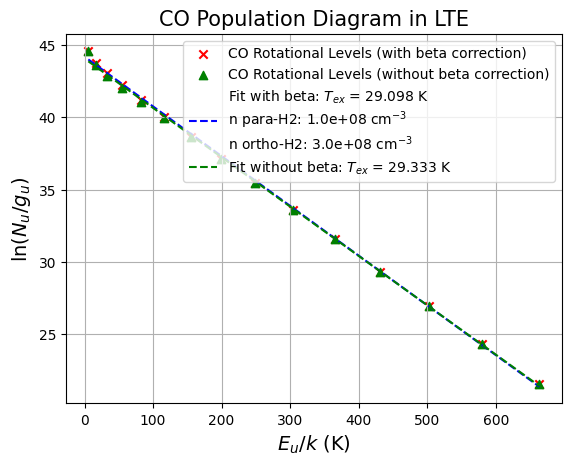

In [26]:
# calculate escape probability for each transition
beta_LTE = (1 - np.exp(-tauCo)) / tauCo

# create a mask for tau_co values greater than 0.1, returns a boolean array
mask_tau_LTE = tauCo > 0.0001

# initialize y_values_LTE with the values without beta correction
y_values_LTE = np.log(NuCo / gCO)

# apply beta correction only for values where tau_co > 0.1
y_values_LTE[mask_tau_LTE] = np.log(NuCo[mask_tau_LTE] / (gCO[mask_tau_LTE] * beta_LTE[mask_tau_LTE]))

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(
    EuCo,
    y_values_LTE,
    marker="x",
    color="red",
    label="CO Rotational Levels (with beta correction)",
)
plt.scatter(
    EuCo,
    np.log(NuCo / gCO),
    marker="^",
    color="green",
    label="CO Rotational Levels (without beta correction)",
)

plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/ g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# Fit a straight line to estimate T_ex with beta correction
fit_LTE = np.polyfit(EuCo, y_values_LTE, 1)  # Linear fit
T_ex_LTE = -1 / fit_LTE[0]  # Rotational temperature from slope

# Fit a straight line to estimate T_ex without beta correction
fit_no_beta = np.polyfit(EuCo, np.log(NuCo / gCO), 1)  # Linear fit
T_ex_no_beta = -1 / fit_no_beta[0]  # Rotational temperature from slope

# Plot the best-fit line with beta correction
x_fit_LTE = np.linspace(min(EuCo), max(EuCo), 100)
y_fit_LTE = fit_LTE[0] * x_fit_LTE + fit_LTE[1]
plt.plot(
    x_fit_LTE,
    y_fit_LTE,
    linestyle="--",
    color="blue",
    label=(
        f"Fit with beta: $T_{{ex}}$ = {T_ex_LTE:.5g} K\nn para-H2: {para_h2_density:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density:.1e} cm$^{{-3}}$"
    ),
)

# Plot the best-fit line without beta correction
y_fit_no_beta = fit_no_beta[0] * x_fit_LTE + fit_no_beta[1]
plt.plot(
    x_fit_LTE,
    y_fit_no_beta,
    linestyle="--",
    color="green",
    label=(f"Fit without beta: $T_{{ex}}$ = {T_ex_no_beta:.5g} K"),
)

plt.legend()
ax.grid()
plt.show()


### why the one without beta correction is getting a better T_ex????

In [27]:
print(f"Excitation temperature with escape probability correction: {T_ex_LTE:.5g} K")
print(f"Excitation temperature without escape probability correction: {T_ex_no_beta:.5g} K")
print(f"kinetic temperature of the nebula: {Tkin} K")  # kinetic temperature in K)

Excitation temperature with escape probability correction: 29.098 K
Excitation temperature without escape probability correction: 29.333 K
kinetic temperature of the nebula: 30 K


As expected in LTE:
$$T_{ex} = T_{kin}$$

However the y axis have the wrong sign

## Consider the escape propability SKIP THIS SECTION IS FOR TESTING
Escape probability for a homogeneous, static sphere is given by:

 
$$
\beta(\tau_\nu) = \frac{3}{2\tau_\nu} \left( 1 - \frac{2}{\tau_\nu^2} + \left( \frac{2}{\tau_\nu} + \frac{2}{\tau_\nu^2} \right) e^{-\tau_\nu} \right)
$$

$\tau_\nu$ is the optical depth.

Equation for the population diagram taking into acount optical depth is: 
$$
ln{\frac{\gamma_u W}{g_u \beta}}=ln{N/Z}-\frac{E_u}{kT}
$$

In [28]:
def beta_tau_test(tau_nu):
    """Calculate the escape probability for homogeneous, static sphere"""
    if tau_nu.any() == 0:
        return np.inf  # Avoid division by zero
    return (3 / (2 * tau_nu)) * (1 - (2 / tau_nu**2) + ((2 / tau_nu) + (2 / tau_nu**2)) * np.exp(-tau_nu))


In [29]:
# get optical depth
tauCo = cloud.tau_nu(nu=nu0_arrayCo)
tauCo

array([1.06956841e-01, 3.25611039e-01, 4.65027682e-01, 4.37054822e-01,
       3.01008985e-01, 1.59280143e-01, 6.64205958e-02, 2.21495996e-02,
       5.96503111e-03, 1.30535504e-03, 2.33545213e-04, 3.42213425e-05,
       4.12226394e-06, 4.09108383e-07, 3.34768853e-08])

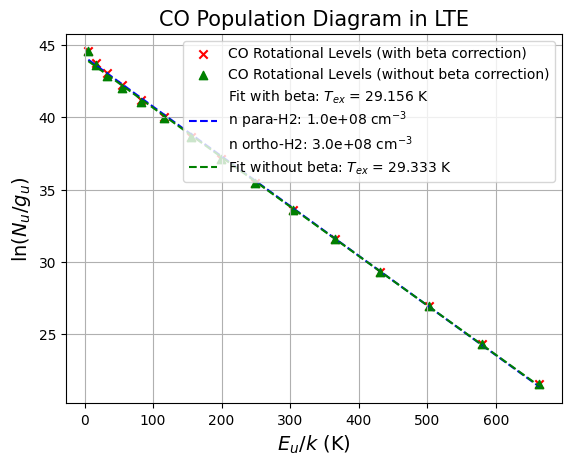

In [30]:
# calculate escape probability for each transition
beta_sphere_correction = beta_tau_test(tauCo)

# create a mask for tau_co values greater than 0.1, returns a boolean array
mask_tau_LTE = tauCo > 0.0001

# initialize y_values_LTE with the values without beta correction
y_values_LTE = np.log(NuCo / gCO)

# apply beta correction only for values where tau_co > 0.1
y_values_LTE[mask_tau_LTE] = np.log(NuCo[mask_tau_LTE] / (gCO[mask_tau_LTE] * beta_sphere_correction[mask_tau_LTE]))

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(
    EuCo,
    y_values_LTE,
    marker="x",
    color="red",
    label="CO Rotational Levels (with beta correction)",
)
plt.scatter(
    EuCo,
    np.log(NuCo / gCO),
    marker="^",
    color="green",
    label="CO Rotational Levels (without beta correction)",
)

plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/ g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# Fit a straight line to estimate T_ex with beta correction
fit_LTE = np.polyfit(EuCo, y_values_LTE, 1)  # Linear fit
T_ex_LTE = -1 / fit_LTE[0]  # Rotational temperature from slope

# Fit a straight line to estimate T_ex without beta correction
fit_no_beta = np.polyfit(EuCo, np.log(NuCo / gCO), 1)  # Linear fit
T_ex_no_beta = -1 / fit_no_beta[0]  # Rotational temperature from slope

# Plot the best-fit line with beta correction
x_fit_LTE = np.linspace(min(EuCo), max(EuCo), 100)
y_fit_LTE = fit_LTE[0] * x_fit_LTE + fit_LTE[1]
plt.plot(
    x_fit_LTE,
    y_fit_LTE,
    linestyle="--",
    color="blue",
    label=(
        f"Fit with beta: $T_{{ex}}$ = {T_ex_LTE:.5g} K\nn para-H2: {para_h2_density:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density:.1e} cm$^{{-3}}$"
    ),
)

# Plot the best-fit line without beta correction
y_fit_no_beta = fit_no_beta[0] * x_fit_LTE + fit_no_beta[1]
plt.plot(
    x_fit_LTE,
    y_fit_no_beta,
    linestyle="--",
    color="green",
    label=(f"Fit without beta: $T_{{ex}}$ = {T_ex_no_beta:.5g} K"),
)

plt.legend()
ax.grid()
plt.show()


# Line profile of CO, LTE case
Spectrum function finds flux density in $W/m^2 Hz$, notice this is just $J/m^2$

fluxes_of_individual_transitions finds flux in $W/m^2$

## Gaussian and total gaussian functions

In [31]:
def gaussian(x, amp, cen, fwhm):
    """
    Gaussian function.

    Parameters:
        x: array-like, the independent variable (e.g., wavelength)
        amp: float, the amplitude of the Gaussian
        cen: float, the center of the Gaussian
        fwhm: float, the full width at half maximum of the Gaussian

    Returns:
        The Gaussian evaluated at x.
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amp * np.exp(-((x - cen) ** 2) / (2 * sigma**2))


# Define the model: a sum of Gaussians.
def model_spectrum(x, params):
    """
    Create spectrum, sum of Gaussians.

    Parameters:
        x: array-like, the independent variable (e.g., wavelength)
        params: list or array of parameters. For n Gaussians, params should be of length 3*n,
                where each Gaussian has [amp, cen, fwhm] in order.

    Returns:
        The sum of Gaussians evaluated at x.
    """
    n_gauss = len(params) // 3
    total = np.zeros_like(x)
    for i in range(n_gauss):
        amp = params[3 * i]
        cen = params[3 * i + 1]
        fwhm = params[3 * i + 2]
        total += gaussian(x, amp, cen, fwhm)
    return total


## Spectrum using flux  

### Frequency space

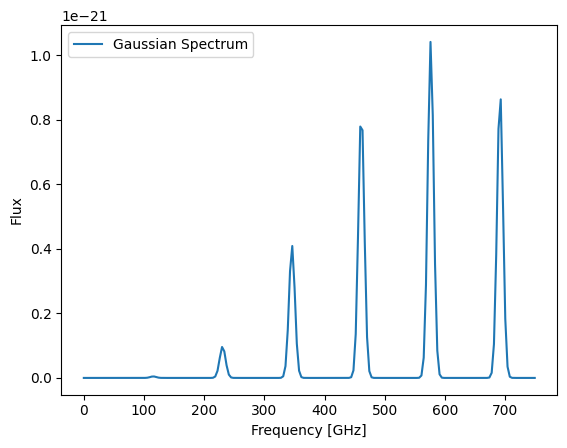

In [32]:
# arbitarry fwhm
fwhm_frequancy = nu0_arrayCo[0] * 0.1

# Example usage
x = np.linspace(0, nu0_arrayCo[5] + 5 * fwhm_frequancy, 200)
params = []
for i in range(NUM_TRANSITIONS):
    # fwhm_frequancy = nu0_arrayCo[i] * 0.1
    params.extend([fluxCo[i], nu0_arrayCo[i], fwhm_frequancy])

# Generate the spectrum
spectrum = model_spectrum(x, params)

# Plot the spectrum
fig, ax = plt.subplots()
plt.plot(x / constants.giga, spectrum, label="Gaussian Spectrum")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.show()

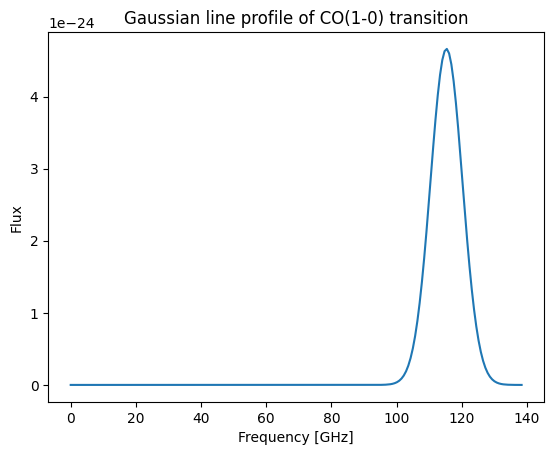

In [33]:
x = np.linspace(0, nu0_arrayCo[0] + 2 * fwhm_frequancy, 200)
gaus_frequancy = gaussian(x, fluxCo[0], nu0_arrayCo[0], fwhm_frequancy)

# plot frequency vs flux
fig, ax = plt.subplots()
plt.title("Gaussian line profile of CO(1-0) transition")
plt.plot(x / constants.giga, gaus_frequancy)
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.show()

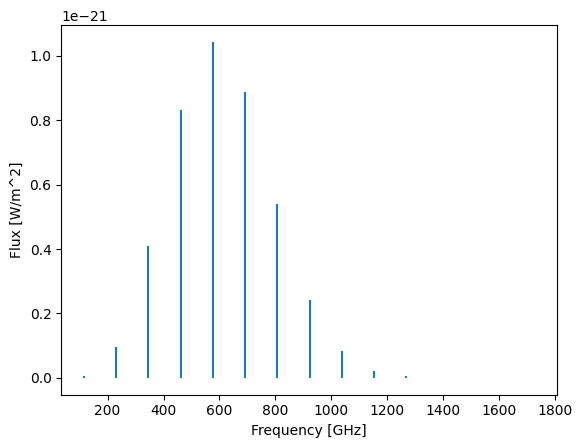

In [34]:
# plot the spectrum with individual fluxes
plt.stem(nu0_arrayCo / constants.giga, fluxCo, basefmt=" ", markerfmt=" ")

# to plot as a gaussina curve
# plt.plot(array_nu0 / constants.giga, flux, drawstyle="steps-mid")

plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux [W/m^2]")
plt.show()

### Velocity space

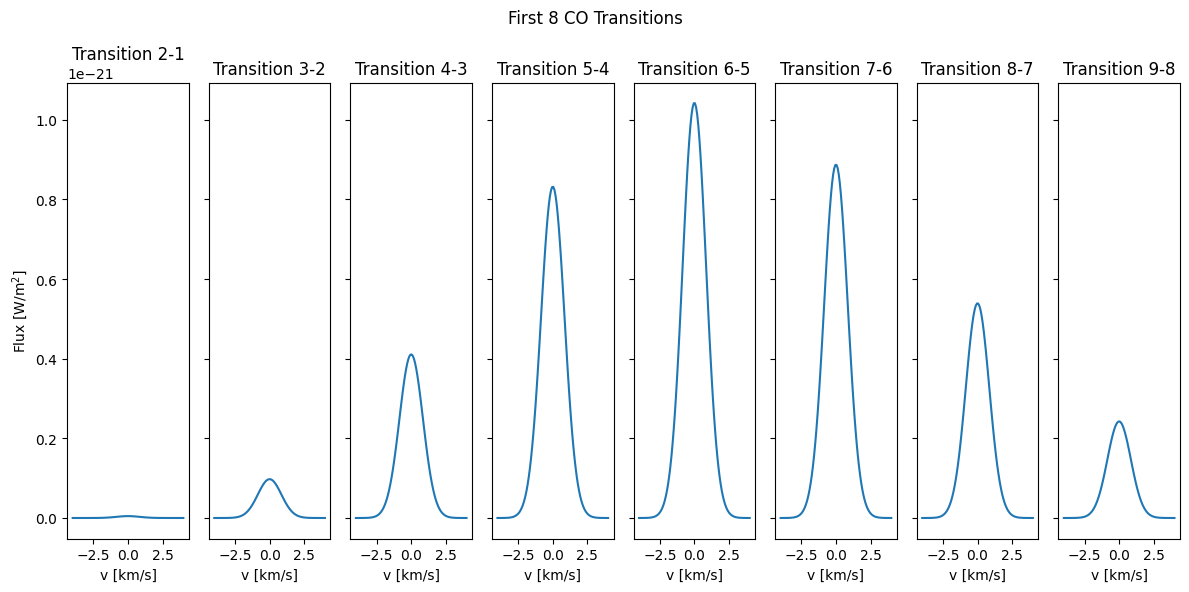

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCo[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity

    # Calculate Gaussian profile
    fwhm = nu0 * (width_v / constants.c)
    spectrum = gaussian(nu, fluxCo[i], nu0, fwhm)

    ax = axes[i]
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"Flux [W/m$^2$]")

fig.tight_layout()
plt.show()

## Spectum in velocity space using flux density 

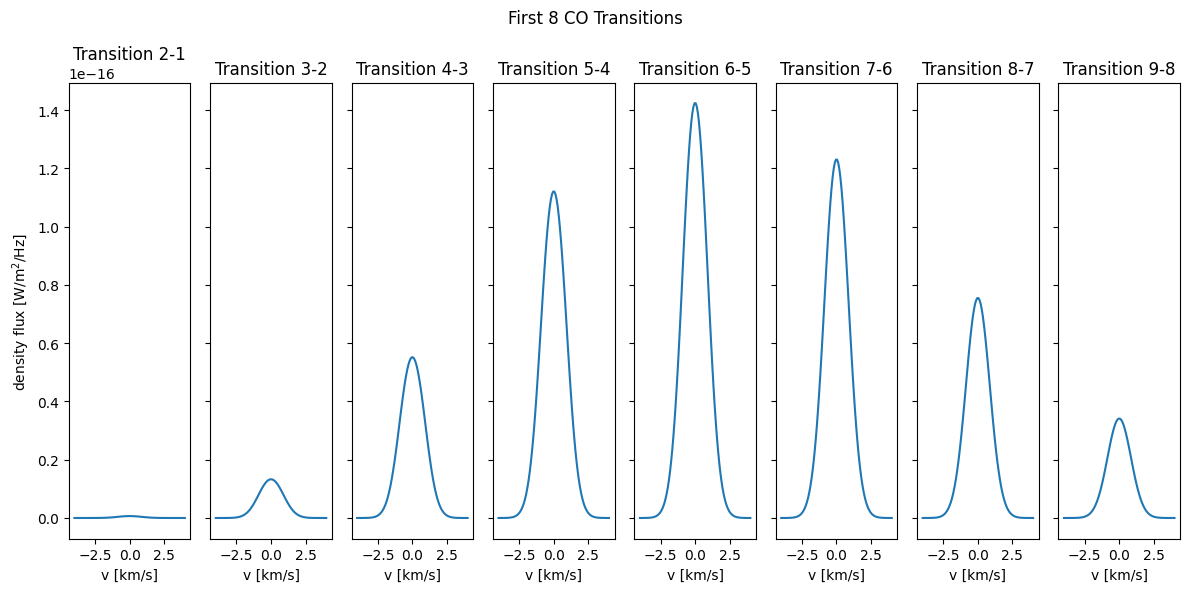

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCo[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(
        nu=nu, solid_angle=source_solid_angle
    )  # Compute spectrum, this give the flux density in W/m^2Hz

    ax = axes[i]
    ax.plot(v / constants.kilo, spectrum * nu)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"density flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

# CO for non-LTE case

## Update cloud

In [37]:
# update the claud using low densities of h2
# collider densities in cm-3:
para_h2_density_nonLTE = 1e3
ortho_h2_density_nonLTE = 3e3


collider_densities_nonLTE = {
    "para-H2": para_h2_density_nonLTE / constants.centi**3,
    "ortho-H2": ortho_h2_density_nonLTE / constants.centi**3,
}

cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_nonLTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

cloud.solve_radiative_transfer()

In [38]:
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      47.54       0.149605       0.399512       0.116755
   2    1     230.538000      15.00       0.399512       0.318472       0.986544
   3    2     345.795990      11.93       0.318472       0.110919        1.01856
   4    3     461.040768      10.92       0.110919      0.0188178       0.389683
   5    4     576.267931      12.20      0.0188178     0.00238214      0.0662424
   6    5     691.473076      14.02     0.00238214    0.000263832     0.00830467
   7    6     806.651806      15.82    0.000263832    2.63356e-05    0.000912979
   8    7     921.799700      17.29    2.63356e-05    2.31209e-06    9.08847e-05
   9    8    1036.912393      18.44    2.31209e-06    1.74012e-07    7.97939e-06
  10    9    1151.985452      19.43    1.74012e-07    1.11753e-08    6.00295e-07
  11   10    1267.014486      20.16    1.11753e-08    5.99237e-10    3.85888e-08
  12   11    1381.995105   

## Plot spectrum lines, non-LTE case

In [39]:
# get the values from the non-LtE cloud object and the data file
TexCo_nonLTE, tauCo_nonLTE, _, _, _, _, _, gammaCo_nonLTE, tau_manualCo_nonLTE, _, NuCo_nonLTE, NlCo_nonLTE = (
    extract_and_calculate(cloud, data_co, N, width_v, Tkin)
)

# Slice all the arrays to get only the first NUM_TRANSITIONS transitions
TexCo_nonLTE = TexCo_nonLTE[:NUM_TRANSITIONS]
tauCo_nonLTE = tauCo_nonLTE[:NUM_TRANSITIONS]
gammaCo_nonLTE = gammaCo_nonLTE[:NUM_TRANSITIONS]
tau_manualCo_nonLTE = tau_manualCo_nonLTE[:NUM_TRANSITIONS]
NuCo_nonLTE = NuCo_nonLTE[:NUM_TRANSITIONS]
NlCo_nonLTE = NlCo_nonLTE[:NUM_TRANSITIONS]


Size of levels: 41
Size of rad_transitions: 40
Size of nu0_array: 40
Are tau_nu function and equation for tau (using kinetic temperature) the same? False
Are tau_nu function and equation for tau (using exitation temperature) the same? False
Are tau_nu0_individual_transitions function and tau_nu function the same? True


In [40]:
# calculate the observed fluxes [W/m2], outputed as a list
flux_nonLTE = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)

# convert flux to np.array
flux_nonLTE = np.array(flux_nonLTE)

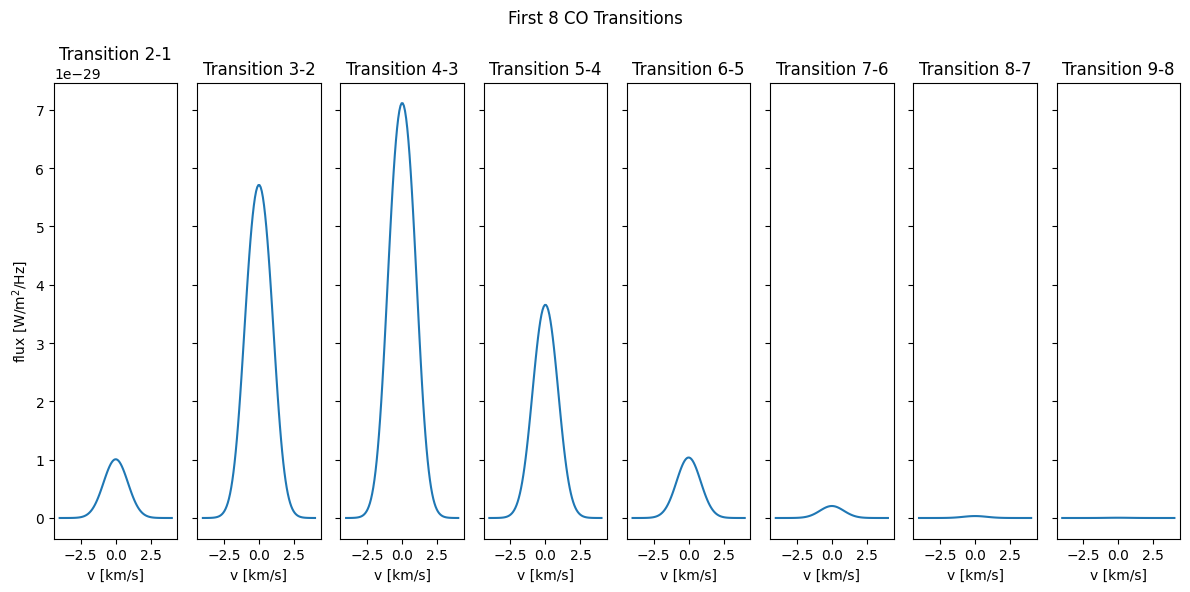

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCo[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(nu=nu, solid_angle=source_solid_angle)  # Compute spectrum

    ax = axes[i]  # Select subplot in 2x4 grid
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

## Plot CO population diagram, non-LTE case

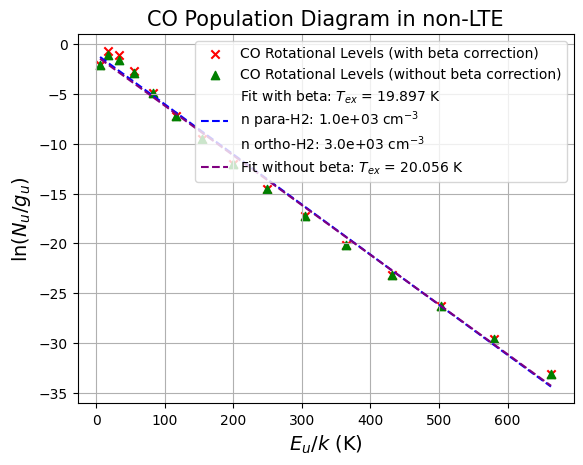

In [42]:
# Define the number of transitions
num_transitions = 15

# calculate escape probability for each transition
beta_nonLTE = (1 - np.exp(-tauCo_nonLTE)) / tauCo_nonLTE

# create a mask for tau_co_nonLTE values greater than 0.1, returns a boolean array
mask_tau = tauCo_nonLTE > 0.1

# initialize y_values_nonLTE with the values without beta correction
y_values_nonLTE = np.log(tauCo_nonLTE / gCO)

# apply beta correction only for values where tau_co_nonLTE > 0.1
y_values_nonLTE[mask_tau] = np.log(tauCo_nonLTE[mask_tau] / (gCO[mask_tau] * beta_nonLTE[mask_tau]))

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCo, y_values_nonLTE, marker="x", color="red", label="CO Rotational Levels (with beta correction)")
plt.scatter(
    EuCo, np.log(tauCo_nonLTE / gCO), marker="^", color="green", label="CO Rotational Levels (without beta correction)"
)
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/ g_u)$", fontsize=14)
plt.title("CO Population Diagram in non-LTE", fontsize=15)

# Fit a straight line to estimate T_ex with beta correction
fit = np.polyfit(EuCo, y_values_nonLTE, 1)  # Linear fit
T_ex_nonLTE = -1 / fit[0]  # Rotational temperature from slope

# Fit a straight line to estimate T_ex without beta correction
fit_no_beta = np.polyfit(EuCo, np.log(tauCo_nonLTE / gCO), 1)  # Linear fit
T_ex_nonLTE_no_beta = -1 / fit_no_beta[0]  # Rotational temperature from slope

# Plot the best-fit line with beta correction
x_fit = np.linspace(min(EuCo), max(EuCo), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(
        f"Fit with beta: $T_{{ex}}$ = {T_ex_nonLTE:.5g} K\nn para-H2: {para_h2_density_nonLTE:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density_nonLTE:.1e} cm$^{{-3}}$"
    ),
)

# Plot the best-fit line without beta correction
y_fit_no_beta = fit_no_beta[0] * x_fit + fit_no_beta[1]
plt.plot(
    x_fit,
    y_fit_no_beta,
    linestyle="--",
    color="purple",
    label=(f"Fit without beta: $T_{{ex}}$ = {T_ex_nonLTE_no_beta:.5g} K"),
)

plt.legend()
ax.grid()
plt.show()

In [43]:
print(f"Excitation temperature: {T_ex_nonLTE:.5g} K")
print(f"Excitation temperature without beta correction: {T_ex_nonLTE_no_beta:.5g} K")
print(f"Kinetic temperature of the cloud: {Tkin} K")  # kinetic temperature in K)

Excitation temperature: 19.897 K
Excitation temperature without beta correction: 20.056 K
Kinetic temperature of the cloud: 30 K


# plot population diagram using equation for non-LTE

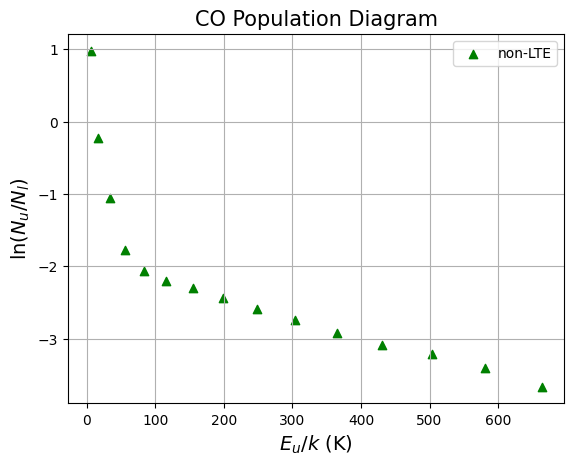

In [44]:
# plot log(Nu/Nl) vs Eu/k
fig, ax = plt.subplots()
# plt.scatter(EuCo, np.log(NuCo / NlCo), marker="x", color="red", label="LTE")
plt.scatter(EuCo, np.log(NuCo_nonLTE / NlCo_nonLTE), marker="^", color="green", label="non-LTE")
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/N_l)$", fontsize=14)
plt.title("CO Population Diagram", fontsize=15)
plt.legend()
ax.grid()
plt.show()

# Plot population diagram for CH3OH-e

In [45]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CH3OH from LAMBDA database
datafilepath_methanol = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\e_ch3oh.dat"  # file downloaded from LAMDA database

# store the data
data_methanol = LAMDA_file.read(datafilepath_methanol, read_frequencies=False)

# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
Ntot_emeth = 1e16 / constants.centi**3  # total column density in m^-2
line_profile_type = "Gaussian"  # line profile, can be "rectangular" or "Gaussian"
width_v = 2 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud_metahnol = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

N = 1e16 / constants.centi**2  # CH3OH_e column density in m-2

# collider densities in m-3, for ch3oh-e ther is only one input parameter, hence no distinction between para- an otho-H2
LTE_collider_densities_h2only = {"H2": 1e8 / constants.centi**3}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud_metahnol.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer, i.e. calculate the level population with an iterative method
cloud_metahnol.solve_radiative_transfer()

79-78: tau_nu0 = -0.0189
46-45: tau_nu0 = -0.0535
28-27: tau_nu0 = -8.75e-06
91-89: tau_nu0 = -1.7e-05
13-12: tau_nu0 = -0.165
18-17: tau_nu0 = -0.18
10-8: tau_nu0 = -0.0918
23-22: tau_nu0 = -0.174
30-27: tau_nu0 = -0.159
37-36: tau_nu0 = -0.136
44-43: tau_nu0 = -0.101
54-53: tau_nu0 = -0.0681
65-64: tau_nu0 = -0.0403
49-48: tau_nu0 = -1.3e-12
79-77: tau_nu0 = -0.0217
92-91: tau_nu0 = -0.0106
105-104: tau_nu0 = -0.00443
121-120: tau_nu0 = -0.00183
68-66: tau_nu0 = -7.47e-06
9-7: tau_nu0 = -0.124
86-85: tau_nu0 = -0.000609
92-89: tau_nu0 = -0.00745
59-56: tau_nu0 = -0.0125
104-103: tau_nu0 = -5.39e-06
58-55: tau_nu0 = -2.16e-12
80-78: tau_nu0 = -3e-06
105-103: tau_nu0 = -0.00251
120-117: tau_nu0 = -1.09e-06
66-63: tau_nu0 = -1.93e-12
121-117: tau_nu0 = -0.000745
135-132: tau_nu0 = -9.72e-08


c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'
c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


In [46]:
cloud_metahnol.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
  79   78       2.937966      -0.43    0.000583222    0.000884515     -0.0189449
  14   13       3.387655       2.24      0.0285947      0.0341875    5.31779e-06
  96   95       7.284957       2.38    0.000115507    0.000109211     0.00105258
  30   28       9.413483      17.09      0.0197465      0.0166671    2.98087e-05
  46   45       9.923130      -4.93     0.00548232     0.00674886     -0.0534514
   5    4      12.171574       6.34      0.0502438      0.0327285        0.73659
 132  131      14.899685       2.24    1.87609e-05    1.27468e-05    6.23153e-06
  28   27      15.619187     -12.16      0.0160904      0.0197465   -8.75294e-06
  58   56      18.347298       5.25     0.00298288     0.00225659    9.73645e-06
   8    7      19.966178      32.46      0.0362893      0.0251669      0.0817325
  42   40      22.304559       4.24     0.00583529     0.00383486    4.73766e-13
  78   77      23.383812   

In [48]:
# # extract_values from the cloud object and the data file
# TexCH3OH, tauCH3OH, AulCH3OH, BulCH3OH, nu0_arrayCH3OH, EuCH3OH, gCH3OH, gammaCH3OH, tau_manualCH3OH, NuCH3OH = (
#     extract_and_calculate(cloud_metahnol, data_methanol, N, width_v, Tkin)
# )

# # Take only N first transitions
# firstN_transitions = 10
# TexCH3OH = TexCH3OH[:firstN_transitions]
# tauCH3OH = tauCH3OH[:firstN_transitions]
# AulCH3OH = AulCH3OH[:firstN_transitions]
# BulCH3OH = BulCH3OH[:firstN_transitions]
# nu0_arrayCH3OH = nu0_arrayCH3OH[:firstN_transitions]
# EuCH3OH = EuCH3OH[:firstN_transitions]
# gCH3OH = gCH3OH[:firstN_transitions]


# # compute the flux from the cloud
# distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
# source_radius = 10 * constants.au  # radius of the source in m
# # solid angle of the source
# source_solid_angle = source_radius**2 * np.pi / distance_observer**2


# flux_methanol = cloud_metahnol.fluxes_of_individual_transitions(
#     transitions=list(range(10)), solid_angle=source_solid_angle
# )

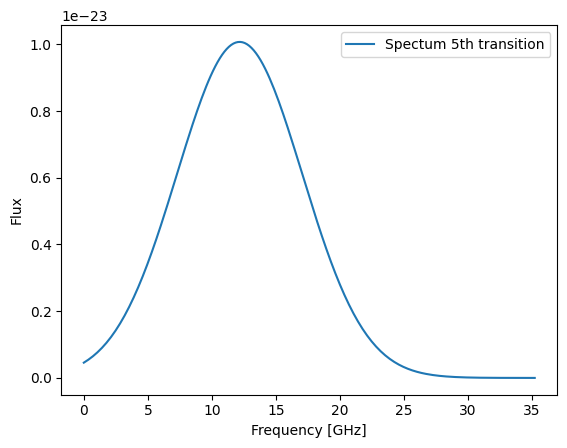

In [ ]:
# # arbitarry fwhm
# fwhm_frequancy = nu0_arrayCo[0] * 0.1

# choose_transition = 5

# # Example usage
# x = np.linspace(0, nu0_arrayCH3OH[choose_transition] + 2 * fwhm_frequancy, 200)
# gaus_frequancy = gaussian(x, flux_methanol[choose_transition], nu0_arrayCH3OH[choose_transition], fwhm_frequancy)

# # plot frequency vs flux
# fig, ax = plt.subplots()
# plt.plot(x / constants.giga, gaus_frequancy, label="Spectum 5th transition")
# plt.xlabel("Frequency [GHz]")
# plt.ylabel("Flux")
# plt.legend()
# plt.show()

In [ ]:
# # compute flux for the first 10 transitions

# # compute the flux from the cloud
# distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
# source_radius = 10 * constants.au  # radius of the source in m
# # solid angle of the source
# source_solid_angle = source_radius**2 * np.pi / distance_observer**2

# frequancy_test = np.arange(1, 20, 0.005) * constants.giga

# # spectrum_methanol = cloud_metahnol.spectrum(solid_angle=source_solid_angle, nu=nu0_arrayCH3OH[:10])

# spectrum_methanol = cloud_metahnol.spectrum(solid_angle=source_solid_angle, nu=frequancy_test)

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\flux.py:175: RuntimeWarning: invalid value encountered in divide
  S_tot = np.where(self.tau_nu_tot==0,0,S_nu/self.tau_nu_tot)
